In [1]:
import matplotlib.pyplot as plt
import numpy as np
from sktime.forecasting.exp_smoothing import ExponentialSmoothing
from sktime.forecasting.compose import EnsembleForecaster

#Online Expert Files
from sktime.forecasting.ensemble_algorithms import *
from sktime.forecasting.online_experts import *
from sktime.forecasting.online_ensemble import OnlineEnsembleForecaster

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from sktime.datasets import load_airline
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.performance_metrics.forecasting import smape_loss
from sktime.utils.plotting.forecasting import plot_ys

%matplotlib inline

# Airline Dataset Problem Setup

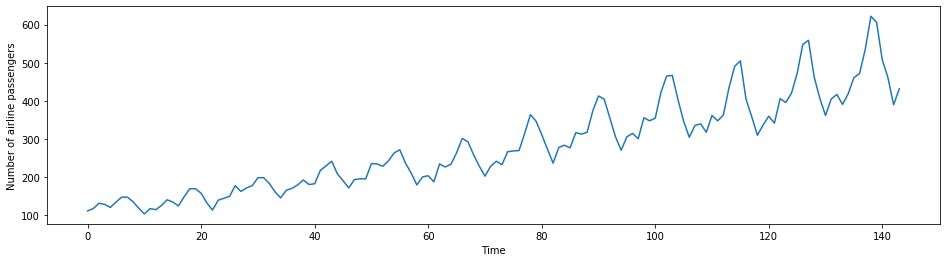

In [3]:
y = load_airline()
fig, ax = plot_ys(y)
ax.set(xlabel="Time", ylabel="Number of airline passengers");

In [4]:
y_train, y_test = temporal_train_test_split(y, test_size=36)
print(y_train.shape[0], y_test.shape[0])

108 36


In [5]:
fh = np.arange(len(y_test)) + 1
fh

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36])

# Ensemble Algorithms

## Averaging Ensemble

In [6]:
forecaster = EnsembleForecaster([
    ("ses", ExponentialSmoothing(seasonal="multiplicative", sp=12)),
    ("holt", ExponentialSmoothing(trend="add", damped=False, seasonal="multiplicative", sp=12)),
    ("damped", ExponentialSmoothing(trend="add", damped=True, seasonal="multiplicative", sp=12))
])

forecaster.fit(y_train,fh=np.arange(1)+1)

/home/memo/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:744: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


EnsembleForecaster(forecasters=[('ses',
                                 ExponentialSmoothing(damped=False,
                                                      damping_slope=None,
                                                      optimized=True,
                                                      remove_bias=False,
                                                      seasonal='multiplicative',
                                                      smoothing_level=None,
                                                      smoothing_seasonal=None,
                                                      smoothing_slope=None,
                                                      sp=12, trend=None,
                                                      use_basinhopping=False,
                                                      use_boxcox=False)),
                                ('holt',
                                 ExponentialSmoothing(damped=False,
                             

In [7]:
fh = np.arange(len(y_test)) + 1
predict = forecaster._predict(fh)

[]

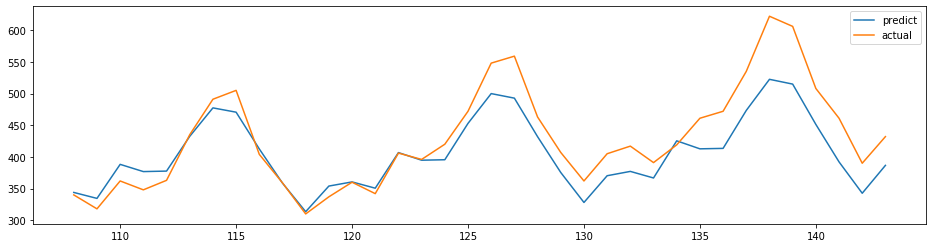

In [8]:
plot_ys(predict,y_test,labels=['predict','actual'])
plt.plot()

In [9]:
np.sum(se(predict.to_numpy(),y_test.to_numpy()))

58100.189521643995

In [10]:
smape_loss(predict[1:],y_test[1:])

0.07189220095667745

## Normal Hedge Algorithm Ensemble

In [11]:
loss_func = lambda x,y: se(x/600,y/600)
# hedge_expert = HedgeExpertEnsemble(3,80,OnlineHedgeDoubling,loss_func=loss_func)
hedge_expert = HedgeExpertEnsemble(3,80,NormalHedge,loss_func=loss_func)

In [12]:
forecaster = OnlineEnsembleForecaster(hedge_expert,[
    ("ses", ExponentialSmoothing(seasonal="multiplicative", sp=12)),
    ("holt", ExponentialSmoothing(trend="add", damped=False, seasonal="multiplicative", sp=12)),
    ("damped", ExponentialSmoothing(trend="add", damped=True, seasonal="multiplicative", sp=12))
])

In [13]:
forecaster.fit(y_train)
predict = forecaster.update_predict(y_test)

/home/memo/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:744: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


In [14]:
forecaster.ensemble_algorithm.weights

array([0.        , 0.55132043, 0.44867957])

[]

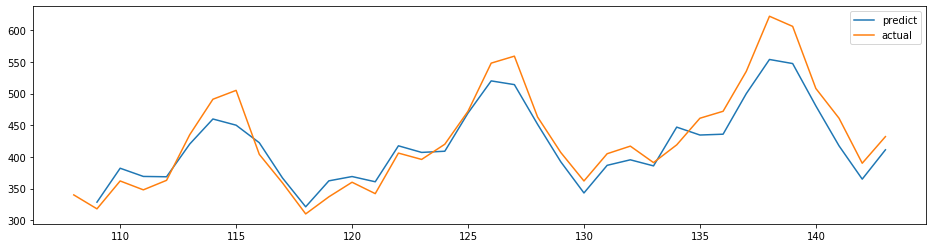

In [15]:
plot_ys(predict,y_test,labels=['predict','actual'])
plt.plot()

In [16]:
np.sum(se(predict.to_numpy(),y_test.to_numpy()[1:]))

27364.184106316083

In [17]:
smape_loss(predict,y_test.iloc[1:])

0.05258677822067323

## NNLS Ensemble

In [18]:
hedge_expert = NNLSEnsemble(3,loss_func=loss_func)

In [19]:
forecaster = OnlineEnsembleForecaster(hedge_expert,[
    ("ses", ExponentialSmoothing(seasonal="multiplicative", sp=12)),
    ("holt", ExponentialSmoothing(trend="add", damped=False, seasonal="multiplicative", sp=12)),
    ("damped", ExponentialSmoothing(trend="add", damped=True, seasonal="multiplicative", sp=12))
])

In [20]:
forecaster.fit(y_train)

/home/memo/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:744: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


OnlineEnsembleForecaster(ensemble_algorithm=<sktime.forecasting.ensemble_algorithms.NNLSEnsemble object at 0x7f316338b5d0>,
                         forecasters=[('ses',
                                       ExponentialSmoothing(damped=False,
                                                            damping_slope=None,
                                                            optimized=True,
                                                            remove_bias=False,
                                                            seasonal='multiplicative',
                                                            smoothing_level=None,
                                                            smoothing_seasonal=None,
                                                            smoothing_slope=None,
                                                            sp=12, trend=None,
                                                            use_basinhoppin...
                           

In [21]:
forecaster._fit_ensemble(y_test)
predict = forecaster.update_predict(y_test)

array([0.        , 1.02390002, 0.        ])

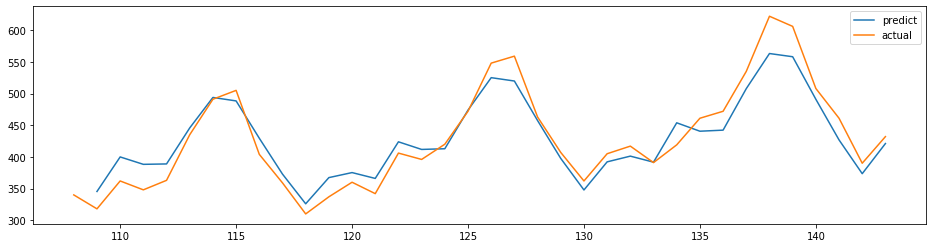

In [22]:
plot_ys(predict,y_test,labels=['predict','actual'])
plt.plot()
forecaster.ensemble_algorithm.weights

In [23]:
np.sum(se(predict.to_numpy(),y_test.to_numpy()[1:]))

21995.40892284908

In [24]:
smape_loss(predict,y_test.iloc[1:])

0.049698255993629634